In [1]:
import numpy as np
import math
import scipy.linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.stats import binom
import scipy
from scipy.special import jv

In [2]:
def tuple_sum(a,b):
    output = ()
    for i in range(len(a)):
        output = output + ((a[i]+b[i]),)
    return output

def create_next_set(set_ini):
    v = set_ini.pop()
    set_ini.add(v)
    N = len(v)
    idty = np.eye(N,dtype=int)
    output = set()
    for i in set_ini:
        for j in idty:
            j = tuple(j)
            output.add(tuple_sum(i,j))
    return output

def create_whole_set(N,Ns):
    ini_vec = tuple((0 for _ in range (Ns)))
    ini_set = set()
    ini_set.add(ini_vec)
    for _ in range(N):
        ini_set = create_next_set(ini_set)
    return ini_set

def create_whole_basis(Na,Nb,Ns):
    set_a = create_whole_set(Na,Ns)
    set_b = create_whole_set(Nb,Ns)
    basis = []
    
    for i in (set_a):
        for j in (set_b):
            #current_vector = np.array((Ns,2))
            current_vector = []
            for k in range(Ns):
                secondary_vector = [i[k],j[k]]
                current_vector.append(secondary_vector)
            current_vector = np.array(current_vector)
            basis.append(current_vector)
            
    return basis
                


In [3]:

def summation(test_tup):
    test = list(test_tup)
    count = 0
    for i in test:
        count += i
    return count


def tuple_sum_fermions(a,b):
    output = ()
    for i in range(len(a)):
        output = output + (((a[i]+b[i]))%2,)
    return output

def create_next_set_fermions(set_ini):
    v = set_ini.pop()
    set_ini.add(v)
    N = len(v)
    idty = np.eye(N,dtype=int)
    output = set()
    for i in set_ini:
        for j in idty:
            j = tuple(j)
            output.add(tuple_sum_fermions(i,j))
    return output

def create_whole_set_fermions(N,Ns):
    ini_vec = tuple((0 for _ in range (Ns)))
    ini_set = set()
    ini_set.add(ini_vec)
    #print("ini vec is ",ini_vec)
    #print("ini set is ",ini_set)
    for _ in range(N):
        ini_set = create_next_set_fermions(ini_set)
        
    ini_set2 = ini_set.copy()
    for _ in ini_set2:
        if (summation(_) != N):
            ini_set.remove(_)
    return ini_set

def create_whole_basis_fermions(Na,Nb,Ns):
    set_a = create_whole_set_fermions(Na,Ns)
    set_b = create_whole_set_fermions(Nb,Ns)
    basis = []
    
    for i in (set_a):
        for j in (set_b):
            #current_vector = np.array((Ns,2))
            current_vector = []
            for k in range(Ns):
                secondary_vector = [i[k],j[k]]
                current_vector.append(secondary_vector)
            current_vector = np.array(current_vector)
            basis.append(current_vector)
            
    return basis

Definition of Operators

In [4]:
def c(ket,i,species):
    outket = ket.copy()

    if (i>(len(ket)-1)):
        k = i - len(ket)
    elif (i<0):
        k = i + len(ket)
    else:
        k=i
        
    if ket[k,species] > 0:
        outfactor = math.sqrt(outket[k,species])
        outket[k,species] = outket[k,species] - 1
    elif ket[k,species] <= 0:
        outfactor = 0
        outket[k,species] = 0
    return outfactor, outket

def c_dagger(ket,i,species):
    outket = ket.copy()
    if (i>(len(ket)-1)):
        outfactor = math.sqrt(outket[i-len(ket),species]+ 1)
        outket[i-len(ket),species] = outket[i-len(ket),species] + 1
    elif (i<0):
        outfactor = math.sqrt(outket[i+len(outket),species]+ 1)
        outket[i+len(outket),species] = outket[i+len(outket),species] + 1
    else:
        outfactor = math.sqrt(outket[i,species]+ 1)
        outket[i,species] = outket[i,species] + 1
    return outfactor,outket

def hopping_right(i,species,ket):
    outket = ket.copy()
    #if (i == len(ket)-1):
        #factor1, outket = c(outket,i,species)
        #factor2, outket = c_dagger(outket,i+1,species)
    #elif (i<(len(ket)-1)):
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i+1,species)
    outfactor = factor1*factor2  
    return outfactor, outket

def hopping_left(i,species,ket):
    outket = ket.copy()
    #if (i == 0):
     #   factor1, outket = c(outket,i,species)
      #  factor2, outket = c_dagger(outket,i-1,species)
    #elif (i>0):
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i-1,species)
    outfactor = factor1*factor2  
    return outfactor, outket

def n(i,species,ket):
    outket = ket.copy()
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i,species)
    outfactor = factor1*factor2
    return outfactor, outket


def superexchange_hopping_right(i,species,ket):
    outket = ket.copy()
    factor0, outket = n(i+1,species,outket)
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i+2,species) 
    outfactor = factor0*factor1*factor2  
    return outfactor, outket

def superexchange_hopping_left(i,species,ket):
    outket = ket.copy()
    factor0, outket = n(i-1,species,outket)
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i-2,species)
    outfactor = factor0*factor1*factor2  
    return outfactor, outket

In [5]:
def H_hopping_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_l,outket_l = hopping_left(i,alpha,ket)
        outfactor_r,outket_r = hopping_right(i,alpha,ket)
        if np.array_equal(bra,outket_l):
            output = output - outfactor_l
        if np.array_equal(bra,outket_r):
            output = output - outfactor_r
    return output


def total_H_hopping_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_hopping_element_single_site(bra,ket,i)
    return output

def build_H_hopping(basis):
    H = np.zeros((len(basis), len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_hopping_element(bra,ket)
    return H


def H_contact_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_c, outket_c = n(i,alpha,ket)    
        if np.array_equal(bra,outket_c):
            output = output + outfactor_c*(outfactor_c-1)*1/2       
    return output


def total_H_contact_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_contact_element_single_site(bra,ket,i)
    return output

def build_H_contact(basis):
    #H = np.zeros((len(basis), len(basis)))
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        #print(i)
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_contact_element(bra,ket)
    return H



def H_fn_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_1, outket_1 = n(i,alpha,ket)
        outfactor_2, outket_2 = n(i+1,alpha,outket_1)
        if np.array_equal(bra,outket_2):
            output = output + outfactor_1*outfactor_2     
    return output


def total_H_fn_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_fn_element_single_site(bra,ket,i)
    return output

def build_H_fn(basis):
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_fn_element(bra,ket)
    return H


def H_dipolar_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_1, outket_1 = n(i,alpha,ket)
        for j in range(len(ket)):
            if (j != i):
                outfactor_2, outket_2 = n(j,alpha,outket_1)
                if np.array_equal(bra,outket_2):
                    output = output + (outfactor_1*outfactor_2)/(distance(i,j,len(ket))**3)
                    
    return output


def total_H_dipolar_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_dipolar_element_single_site(bra,ket,i)
    return output

def build_H_dipolar(basis):
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_dipolar_element(bra,ket)
            
    return H



def H_SE_hopping_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_l,outket_l = superexchange_hopping_left(i,alpha,ket)
        outfactor_r,outket_r = superexchange_hopping_right(i,alpha,ket)
        if np.array_equal(bra,outket_l):
            output = output + outfactor_l
        if np.array_equal(bra,outket_r):
            output = output + outfactor_r
    return output


def total_H_SE_hopping_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_SE_hopping_element_single_site(bra,ket,i)
    return output

def build_H_SE_hopping(basis):
    H = np.zeros((len(basis), len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_SE_hopping_element(bra,ket)
    return H


In [19]:
def function_rsquared(T,a,m):
    return np.sqrt((a**2 + ((T)/(m))**2)/a)

def sigma_mass(xdata,ydata,sigma):
    epsilon = 0.001
    values, cov = curve_fit(sigma_sp, xdata, ydata,bounds=((-np.inf,sigma-epsilon), (np.inf,sigma+epsilon)))

    return values[0], values[1]


def J_eff(m):
    return 1/(2*m)


def sigma_sp(t,m,sigma):
    return np.sqrt(sigma**2 + (t/(sigma*m))**2)


def linear_mass_q0(ratio):
    return (2+16*ratio)

def linear_mass_qpi(ratio):
    return (-2+16*ratio)

def linear_mass_qpihalves(ratio):
    return np.abs(-16*ratio)


In [6]:
def create_H_J_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor1, newket1 = hopping_left(site,species,ket)
                key = basis_dict2.get(str(newket1), -1)
                if ((key) != -1):
                    H[key,i] = H[key,i] + factor1*(-1)
                    
                factor2, newket2 = hopping_right(site,species,ket)
                key = basis_dict2.get(str(newket2), -1)
                if ((key) != -1):
                    H[key,i] = H[key,i] + factor2*(-1)
    #H = H.todense()
    return H


def create_H_U_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor, newket = n(site,species,ket)
                key = basis_dict2.get(str(newket), -1)
                if (key != -1):
                    H[key,i] = H[key,i] + factor*(factor-1)*1/2
                    
    #H = H.todense()
    return H


def create_H_V_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor1, newket = n(site,species,ket)
                factor2, newket = n(site+1,species,newket)
                key = basis_dict2.get(str(newket), -1)
                if (key != -1):
                    H[key,i] = H[key,i] + factor1*factor2
                    
    #H = H.todense()
    return H


def one_over_m_positive(H,Ns):
    #vaps,veps = LA.eigh(H)
    
    vaps_GS = eigs(H, k = Ns, which='SR', return_eigenvectors = False)
    #veps = veps.T
    vaps_GS = np.real(vaps_GS)
    vaps_GS = np.sort(vaps_GS)
    #print(vaps_GS)
    dq = 2*np.pi/Ns
    
    return 2*(vaps_GS[1]-vaps_GS[0])/dq**2
    #return 2*(vaps_GS[1]-vaps_GS[0])/np.sin(dq)**2


def one_over_m_negative(H,Ns):
    #vaps,veps = LA.eigh(H)
    vaps_ES, veps = eigs(H, k = Ns, which='LR')
    #veps = veps.T
    vaps_ES = np.real(vaps_ES)
    vaps_ES = np.sort(vaps_ES)
    #print(vaps_ES)
    dq = 2*np.pi/Ns
    
    #return 2*(vaps_ES[1]-vaps_ES[0])/dq**2
    return 2*(vaps_ES[-1]-vaps_ES[-2])/dq**2
    #return 2*(vaps_ES[1]-vaps_ES[0])/np.sin(dq)**2


In [8]:
def hopping_from_i_to_j(ket,i,j):
    in_ket = ket.copy()
    factor1, newket = c(in_ket,i,0)
    factor2, newket = c_dagger(newket,j,0)
    return factor1*factor2, newket

def create_Q_matrix(basis_dict1,basis_dict2):
    #Q = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    Q  = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    
    Ns = len(basis_dict1[1])
    
    #print("Ns is",Ns)
    
    if (Ns%2 == 0):
        for ket_number in basis_dict1:
            ket = basis_dict1[ket_number]
            for i in range(Ns):
                for j in range(Ns):
                    factorq = 0
                    for k in range(-Ns//2,Ns//2,1):
                        q = 2*np.pi/Ns*k
                        factorq = factorq + q*np.exp(1j*q*(j - i))
                    factor_ket, newket = hopping_from_i_to_j(ket,i,j)
                    factor = factor_ket*factorq
                    key = basis_dict2.get(str(newket), -1)
                    if (key != -1):
                        Q[key,ket_number] = Q[key,ket_number] + factor
                        
    if (Ns%2 != 0):
        for ket_number in basis_dict1:
            ket = basis_dict1[ket_number]
            for i in range(Ns):
                for p in range(Ns):
                    factorq = 0
                    for k in range(-(Ns-1)//2,(Ns-1)//2+1,1):
                        q = 2*np.pi/Ns*k
                        argument = q*(i-p)
                        factorq = factorq + q*np.cos(argument) + q*np.sin(argument)*1j
                    factor_ket, newket = hopping_from_i_to_j(ket,i,p)
                    factor = factor_ket*factorq
                    key = basis_dict2.get(str(newket), -1)
                    if (key != -1):
                        Q[key,ket_number] = Q[key,ket_number] + factor

    return Q/Ns



#NS = np.arange(3,9)
NS = np.array([6])
#NS = np.arange(5,7)

#Us = np.array([-20,-10,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,20])
#Us = np.array([0,1,2,3,4,5,6,7,8,9])
#Us = np.array([0])
#ratios = np.linspace(-1,1,200)

ratios = np.linspace(-0.5,0.5,21)
#print(ratios)
#print(ratios)
print(ratios)
Us = 1/(ratios+0.00001)
#print(Us)
#Us = np.linspace(0,50,51)
#Us = np.arange(0,26,1)
#Us = np.array([0])
#Us1 = np.array([0,0.1,0.2,0.3,0.4,0.5])
#Us2 = np.arange(1,11)
#Us2 = np.append(Us2,200)
#Us = np.concatenate((Us1,Us2))

#Us = np.array([20])
#Us = np.array([0,1,4,5,8,10,15,20,50,100])
#Us = np.array([1,2,3])

#Us = np.array([3,10,20,-3,-10,-20])
#Us = np.array([0.3,-0.3,3,-3,10,-10,0])
#Us = np.array([-3.3,3.3])
#Vs = np.array([-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10])
#Us = np.array([-10,-8,-6,-4,-2,-1,1,2,4,6,8,10])
#Vs = np.array([3,-3,10,-10,20,-20,0])
#Vs = np.array([0,-0.5,-1,-1.5])
#Vs = np.linspace(-1.5,0,20)
Vs = np.array([0])
#Us = np.array([-3.6])
#Us = np.linspace(-4,4,40)

plot_diff_NS = []
plot_eff_masses = np.zeros((len(Us),len(Vs)))

Inverse_masses = np.zeros((len(Us),len(Vs), 2))
Sound_speeds = np.zeros((len(Us),len(Vs), 2))
Shifts = np.zeros((len(Us),len(Vs), 2))
#plot_bands = np.zeros((len(Us)))


for ns in range(len(NS)):
    print("Ns = ",NS[ns])
    Ns = NS[ns]
    Na = Ns-1
    Nb = 0

    basis = create_whole_basis(Na,Nb,Ns)

    basis_dict1 = {}
    basis_dict2 = {}
    for i in range(len(basis)):
        basis_dict1[i] = basis[i]
        basis_dict2[str(basis[i])] = i


    Q = create_Q_matrix(basis_dict1,basis_dict2)
    HJ = create_H_J_sparse(basis_dict1,basis_dict2)
    HU = create_H_U_sparse(basis_dict1,basis_dict2)
    HV = create_H_V_sparse(basis_dict1,basis_dict2)
    #HU = HU.todense()
    #HJ = HJ.todense()

    Second_band = np.zeros((Ns))

    

    Momenta = np.zeros((len(Us),len(Vs),len(basis)))
    Energy = np.zeros((len(Us),len(Vs),len(basis)))


    

    plot_bands = np.zeros((len(Us),len(Vs), Ns, 4))
    print("reached this")
    for __ in range(len(Vs)):
        print(__,":")
        for _ in range(len(Us)):
            print(_)
            H = 1*HJ + Us[_]*HU + Vs[__]*HV

            vaps_q, veps_q = LA.eigh(Q)

            H_Q = np.conj((veps_q).T)@H@veps_q

            vaps_q_1bz = np.zeros((len(vaps_q)))
            veps_q_1bz = np.zeros((len(veps_q)))

            for i in range(len(basis)):
                q = vaps_q[i]
                vaps_q_1bz[i] = move_to_1bz(q)


            veps_q = veps_q.T


            order = np.argsort(vaps_q_1bz)    


            H_Q_ordered = H_Q[order].T[order].T


            H_Q_ordered_imag = np.imag(H_Q_ordered)
            H_Q_ordered_real = np.real(H_Q_ordered)

            for i in range(len(H_Q_ordered_imag)):
                for j in range(len(H_Q_ordered_imag)):
                    if (np.abs(H_Q_ordered_imag[i,j]) < 1e-8):
                        H_Q_ordered_imag[i,j] = 0
                    if (np.abs(H_Q_ordered_real[i,j]) < 1e-8):
                        H_Q_ordered_real[i,j] = 0

            #H_Q_ordered_imag[np.abs(H_Q_ordered_imag) < 1e-8] = 0
            #H_Q_ordered_real[np.abs(H_Q_ordered_imag) < 1e-8] = 0


            H_Q_ordered = H_Q_ordered_real + 1j*H_Q_ordered_imag


            H_Q_ordered = lil_matrix((H_Q_ordered))
            #print(np.max(H_Q_ordered- np.conj(H_Q_ordered.T)))

            momenta = vaps_q_1bz[order]
            energies = diagonalization_per_block(momenta,H_Q_ordered)

            for i in range(len(basis)):
                Energy[_,__,i] = energies[i]
                Momenta[_,__,i] = momenta[i]
            #print(Energy[0,0])
            bands = find_EQ1_EQ2(Momenta[_,__],Energy[_,__], Ns)
            #print(bands)
            
            for nss in range(Ns):
                for k in range(4):
                    plot_bands[_,__,nss,k] = bands[nss,k]




            #Inverse_masses[_,0], Sound_speeds[_,0], Shifts[_,0] = curve_fit_bogoliubov(bands)
            #mass1, sound_speed1, shift1 = curve_fit_bogoliubov(bands)

            E0 = bands[Ns//2, 0]
            E1 = bands[Ns//2 - 1, 0]
            E2 = bands[Ns//2 - 2, 0]
            E3 = bands[Ns//2 - 3, 0]

            #print("U = ",Us[_])
            #print(E0)
            #print(E1)
            #print(E2)

            #Inverse_masses[_,1], Sound_speeds[_,1] = equation_system_ns6(E0,E1,E3)
            #Shifts[_,1] = E0

            plot_eff_masses[_,__] = Inverse_masses[_,__,0]
        
    #plot_bands = np.array((plot_bands))
    print(plot_bands)
    #np.reshape(plot_bands, (len(Vs), len(Us)))
    plot_diff_NS.append(plot_bands)

   


[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]
Ns =  6
reached this
0 :
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[[[-2.12454969e+01  7.54748015e+00 -1.52017720e+01  3.98029665e+00]
   [-2.12577749e+01  5.69429720e+00 -1.53427067e+01  3.09431859e+00]
   [-2.12821637e+01  4.41816661e+00 -1.55984484e+01  3.54677250e+00]
   [-2.12942797e+01  3.76002830e+00 -1.57337908e+01  3.45974348e+00]
   [-2.12821637e+01  4.41816661e+00 -1.55984484e+01  3.54677250e+00]
   [-2.12577749e+01  5.69429720e+00 -1.53427067e+01  3.09431859e+00]]]


 [[[-2.33454512e+01  7.34255003e+00 -1.63292977e+01  3.66012537e+00]
   [-2.33535910e+01  5.42943520e+00 -1.64924659e+01  2.92308534e+00]
   [-2.33698031e+01  4.14175835e+00 -1.67249155e+01  3.27582111e+00]
   [-2.33778765e+01  3.53237404e+00 -1.68362383e+01  3.14645234e+00]
   [-2.33698031e+01  4.14175835e+00 -1.67249155e+01  3.27582111e+00]
   [-2.33535910e+01  5.4294352

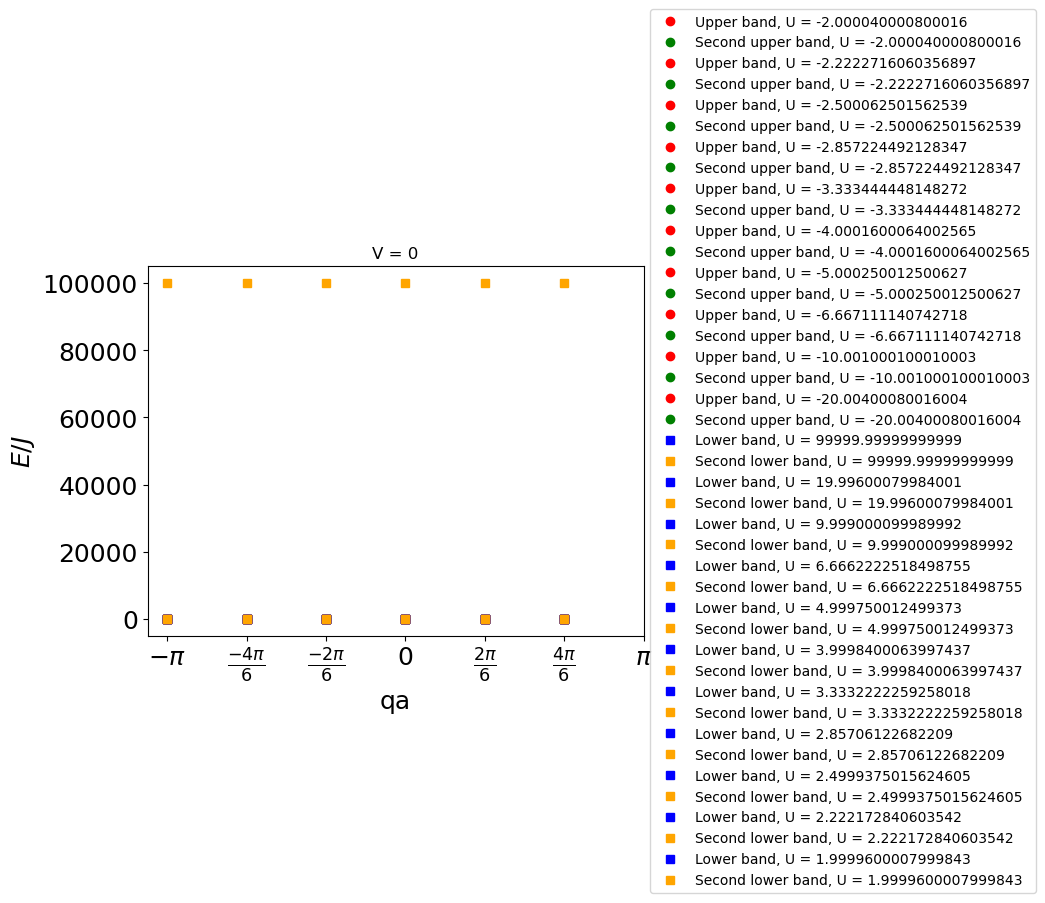

'\n#U,V,q,lower/upper band\nprint("E(q = 2pi/6, U = -0.3, V = 0) = ",plot_bands[0,0,4,1])\nprint("E(q = 0, U = -0.3, V = 0) = ",plot_bands[0,0,3,1])\nprint("difference: ",plot_bands[0,0,4,1]-plot_bands[0,0,3,1])\n\nprint("E(q = 2pi/6, U = -0.3, V = -1) = ",plot_bands[0,2,4,1])\nprint("E(q = 0, U = -0.3, V = -1) = ",plot_bands[0,2,3,1])\nprint("difference: ",plot_bands[0,2,4,1]-plot_bands[0,2,3,1])'

In [12]:
if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns  
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns


X = np.linspace(-np.pi,np.pi,200)

X1 = np.linspace(-np.pi,0,100)
X2 = np.linspace(0,np.pi,200)
    
colors = ["red", "red","green","green", "blue", "blue"]

colors = ["red", "green", "blue", "orange"]
for k in range(len(Vs)):
    for i in range(len(Us)):
        if Us[i] < 0:
            plt.plot(K1,plot_bands[i,k,:,1], "o", color = colors[0], label = r"Upper band, U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,3], "o", color = colors[1], label = r"Second upper band, U = "+str(Us[i]))
            
            #plt.plot(X, effective_dispersion_relation(X,Us[i],6), color = colors[i-1]) 
        elif Us[i] > 0:
            plt.plot(K1,plot_bands[i,k,:,0], "s", color = colors[2], label = r"Lower band, U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,2], "s", color = colors[3], label = r"Second lower band, U = "+str(Us[i]))
            #plt.plot(X, effective_dispersion_relation(X,Us[i],6), color = colors[i])

        elif Us[i] == 0:
            plt.plot(K1,plot_bands[i,k,:,0], "^", color = "orange")#, label = r"U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,1], "^", color = "orange", label = r"U = "+str(Us[i]))

            #plt.plot(X1, -3/np.pi*X1 + 7, ls = "--", color = "orange")
            #plt.plot(X2, 3/np.pi*X2 + 7, ls = "--", color = "orange")
            #plt.plot(X1, -3/np.pi*X1 -10, ls = "--", color = "orange")
            #plt.plot(X2, 3/np.pi*X2 -10, ls = "--", color = "orange")



        cosa = np.array([-np.pi,-4*np.pi/6, -2*np.pi/6,0,2*np.pi/6,4*np.pi/6, np.pi]) 

        plt.legend()
        plt.xlabel("qa", fontsize = 18)
        plt.ylabel(r"$E/J$", fontsize = 18)
        plt.xticks(cosa, [r"$-\pi$", r"$\frac{-4\pi}{6}$", r"$\frac{-2\pi}{6}$", "0", r"$\frac{2\pi}{6}$", r"$\frac{4\pi}{6}$", r"$\pi$"],fontsize = 18)
        #plt.xticks(cosa, [r"$-\pi$", r"$-4\pi/6$", r"$-2\pi/6$", "0", r"$\frac{2\pi}{6}$", r"$\frac{4\pi}{6}$", r"$\pi$"],fontsize = 18)
        plt.yticks(fontsize = 18)
        
        #plt.legend(loc='center center', bbox_to_anchor=(0.5, 1), ncol = 4, fontsize = 11)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.ylim([2.5,7.5])
    plt.title(r"V = "+str(Vs[k]))
    #plt.savefig('V'+str(Vs[k])+'.png',bbox_inches = "tight")
    plt.show()
'''
#U,V,q,lower/upper band
print("E(q = 2pi/6, U = -0.3, V = 0) = ",plot_bands[0,0,4,1])
print("E(q = 0, U = -0.3, V = 0) = ",plot_bands[0,0,3,1])
print("difference: ",plot_bands[0,0,4,1]-plot_bands[0,0,3,1])

print("E(q = 2pi/6, U = -0.3, V = -1) = ",plot_bands[0,2,4,1])
print("E(q = 0, U = -0.3, V = -1) = ",plot_bands[0,2,3,1])
print("difference: ",plot_bands[0,2,4,1]-plot_bands[0,2,3,1])'''

In [10]:
plot_effective_mass = np.zeros((len(NS),len(Us),len(Vs), 2))
plot_effective_mass_order5 = np.zeros((len(NS),len(Us),len(Vs), 2))
plot_first_derivative = np.zeros((len(NS),len(Us), 2))
plot_last_try = np.zeros((len(NS), len(Us)))


for j in range(len(NS)):
    dq = 2*np.pi/NS[j]
    for i in range(len(Us)):
        for ik in range(len(Vs)):
            #if (i < len(plot_bands)//2):
            if (Us[i] < 0):
                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,1]
                fx2 = plot_diff_NS[j][i,ik,NS[j]//2-2,1]
                fx1 = plot_diff_NS[j][i,ik,NS[j]//2-1,1]
                fx0 = plot_diff_NS[j][i,ik,NS[j]//2-0,1]


                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,0]
                #fx2 = plot_diff_NS[j][i,NS[j]//2-2,0]
                #fx1 = plot_diff_NS[j][i,NS[j]//2-1,0]
                #fx0 = plot_diff_NS[j][i,NS[j]//2,0]

                plot_effective_mass_order5[j,i,0] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,0] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,0] = (-3*fx0 + 4fx1 -fx2)/dq

                #plot_last_try[j,i] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)

                plot_effective_mass[j,i,ik,0] = 2*(plot_diff_NS[j][i,ik,NS[j]//2+1,1] - plot_diff_NS[j][i,ik,NS[j]//2,1])/(2*np.pi/NS[j])**2
                plot_effective_mass[j,i,ik,1] = 2*(plot_diff_NS[j][i,ik,1,1] - plot_diff_NS[j][i,ik,0,1])/(2*np.pi/NS[j])**2

                #fx3 = plot_diff_NS[j][i,3,1]
                fx2 = plot_diff_NS[j][i,ik,2,1]
                fx1 = plot_diff_NS[j][i,ik,1,1]
                fx0 = plot_diff_NS[j][i,ik,0,1]


                plot_effective_mass_order5[j,i,ik,1] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,1] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,1] = (-3*fx0 + 4fx1 -fx2)/dq
            else:
            
                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,0]
                fx2 = plot_diff_NS[j][i,ik,NS[j]//2-2,0]
                fx1 = plot_diff_NS[j][i,ik,NS[j]//2-1,0]
                fx0 = plot_diff_NS[j][i,ik,NS[j]//2-0,0]



                plot_effective_mass_order5[j,i,ik,0] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,0] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #print((2*fx0 - 5*fx1 + 4*fx2 - fx3)) 
                #plot_last_try[j,i] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)


                #print(-fx3)
                #plot_first_derivative[j,i,0] = (-3*fx0 + 4fx1 -fx2)/dq

                plot_effective_mass[j,i,ik,0] = 2*(plot_diff_NS[j][i,ik,NS[j]//2+1,0] - plot_diff_NS[j][i,ik,NS[j]//2,0])/(2*np.pi/NS[j])**2
                plot_effective_mass[j,i,ik,1] = 2*(plot_diff_NS[j][i,ik,1,0] - plot_diff_NS[j][i,ik,0,0])/(2*np.pi/NS[j])**2

                #fx3 = plot_diff_NS[j][i,3,0]
                fx2 = plot_diff_NS[j][i,ik,2,0]
                fx1 = plot_diff_NS[j][i,ik,1,0]
                fx0 = plot_diff_NS[j][i,ik,0,0]


                plot_effective_mass_order5[j,i,ik,1] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,1] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,1] = (-3*fx0 + 4fx1 -fx2)/dq


    #print(plot_effective_mass_order5[0,:,0])
    #print(dq)

In [34]:
def fitting_second_derivative(ns,a,b):
    return a + b/(ns**2)

def fit(fd,Ns):
    g = [1,1]
    
    values, var = curve_fit(fitting_second_derivative,Ns,fd, g)
    
    a = values[0]
    b = values[1]
    
    return a, b
    
    

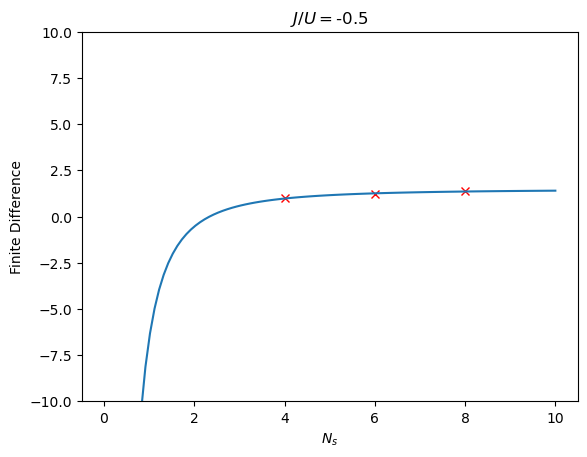

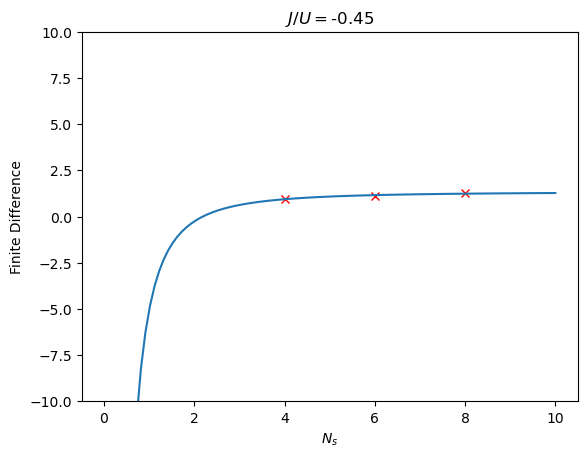

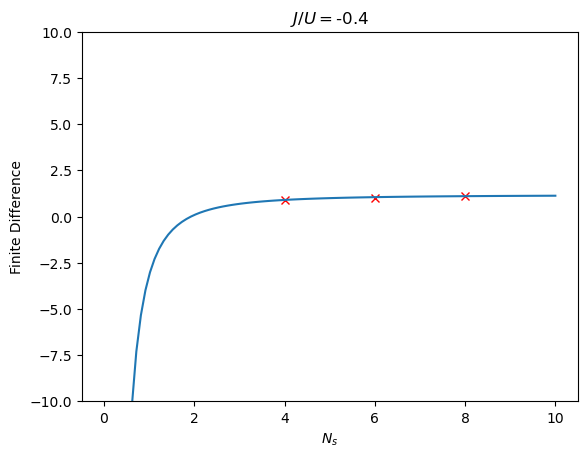

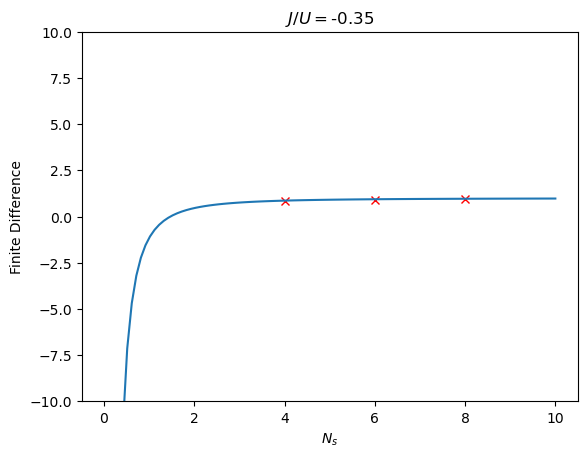

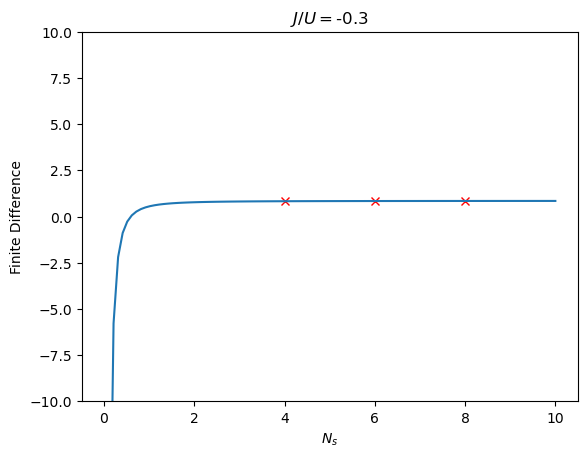

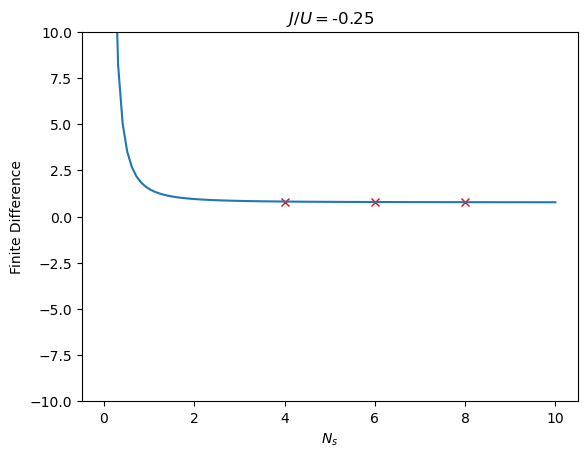

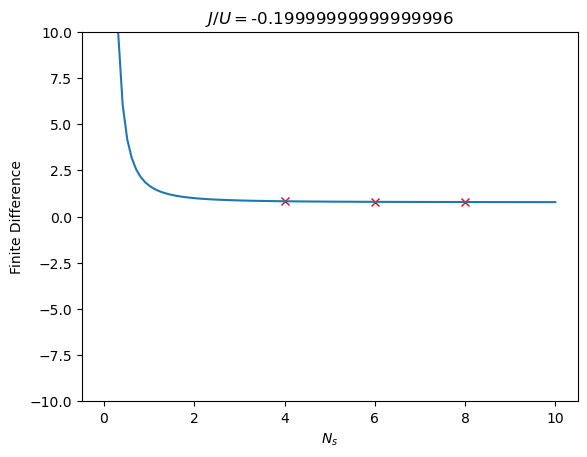

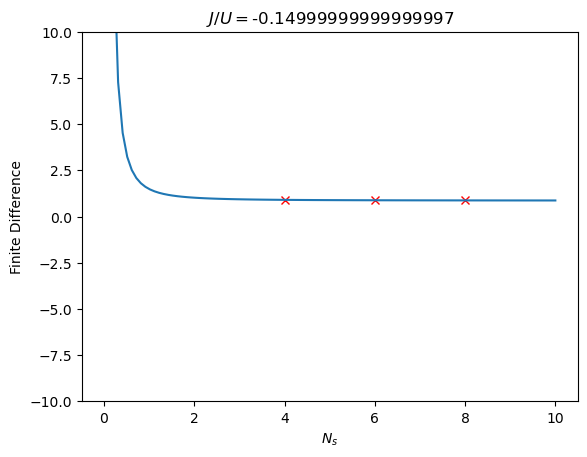

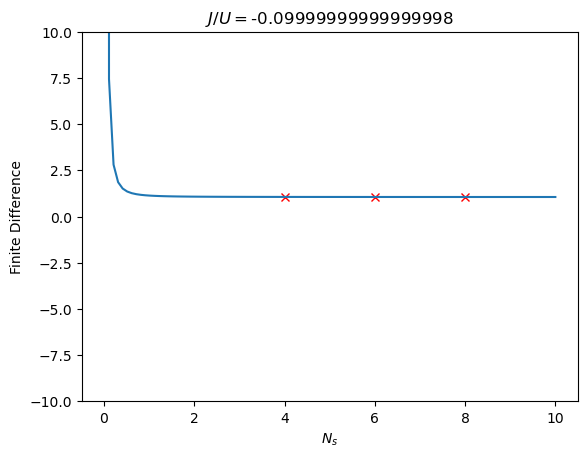

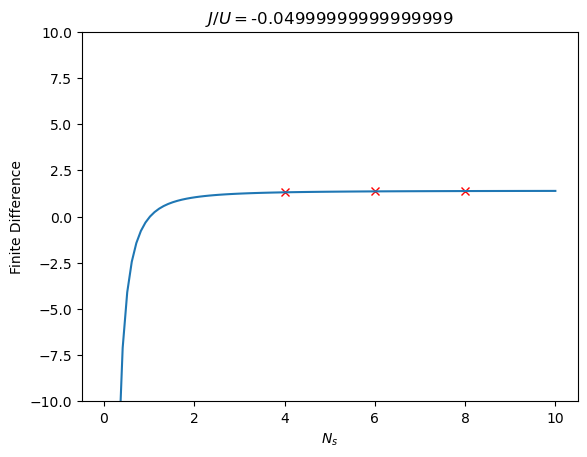

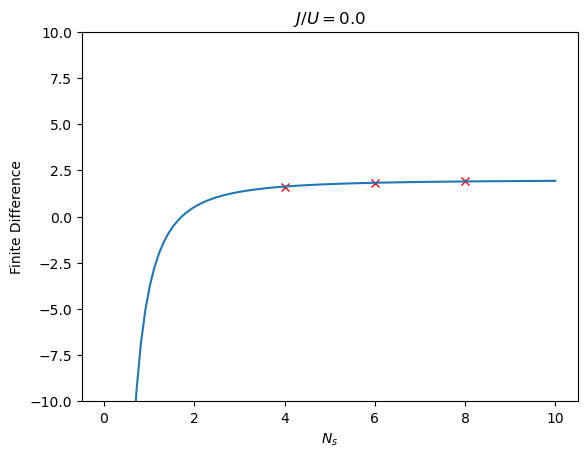

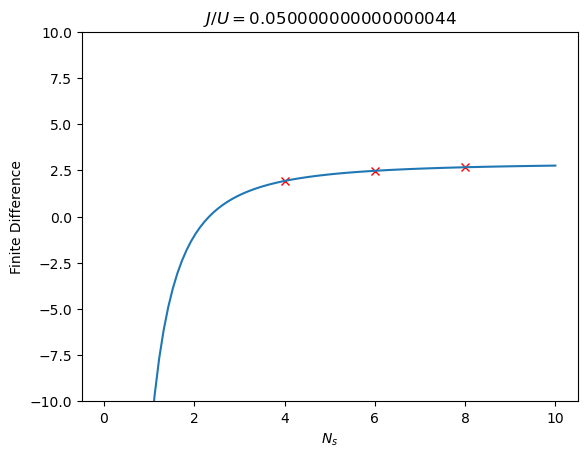

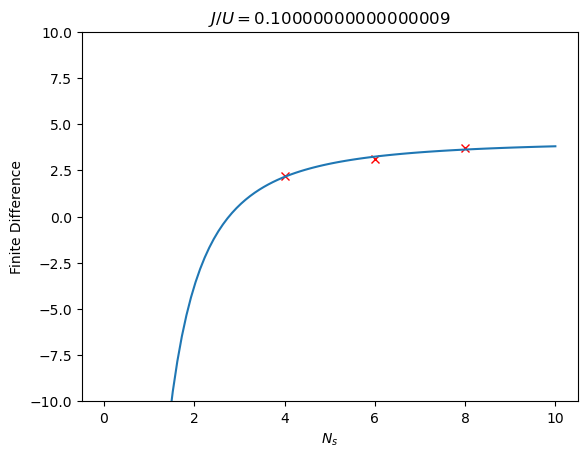

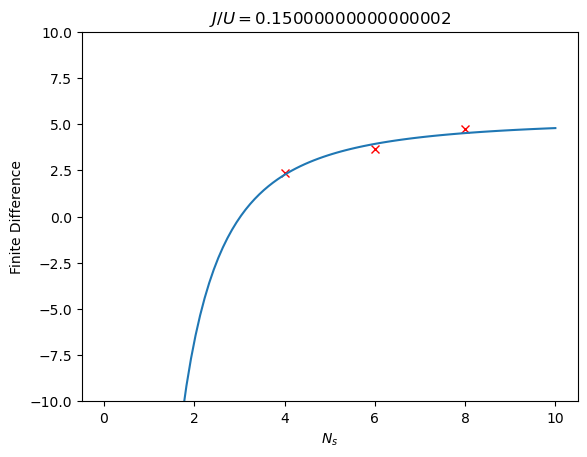

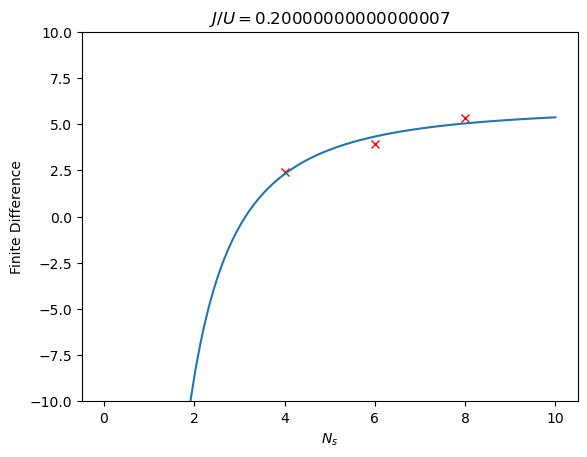

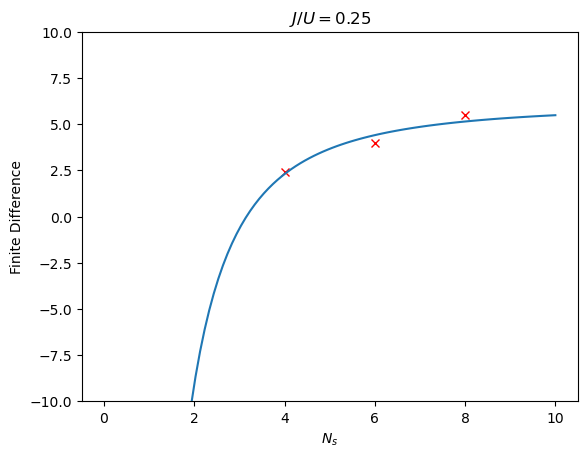

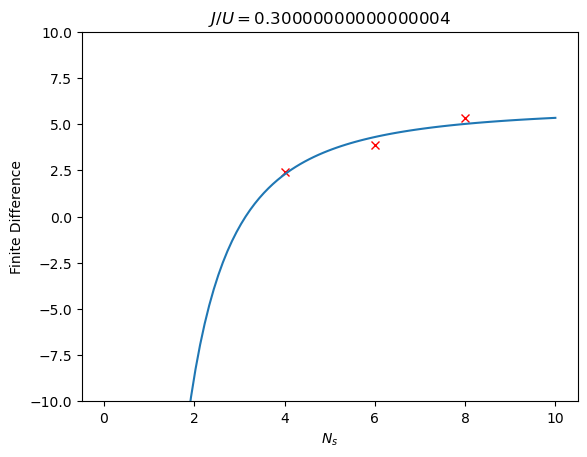

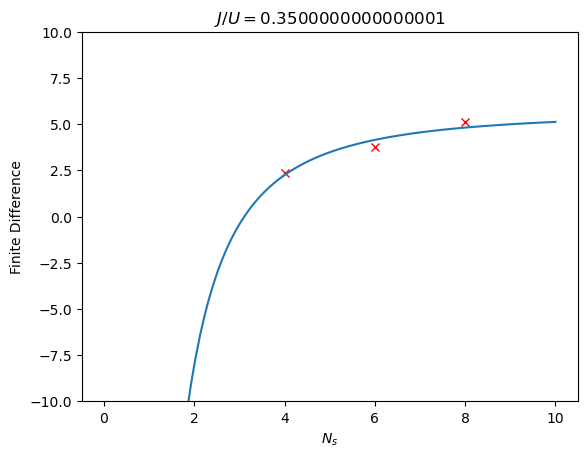

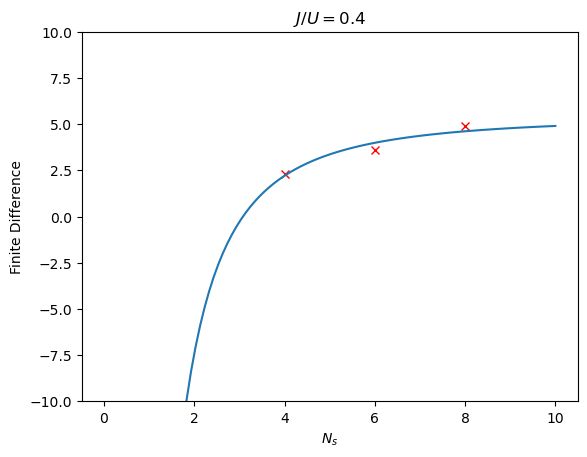

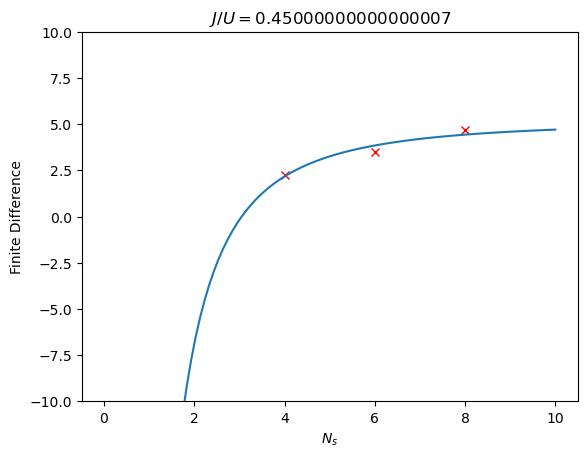

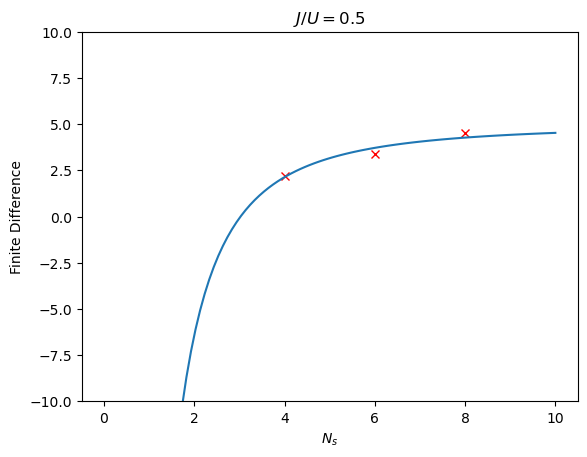

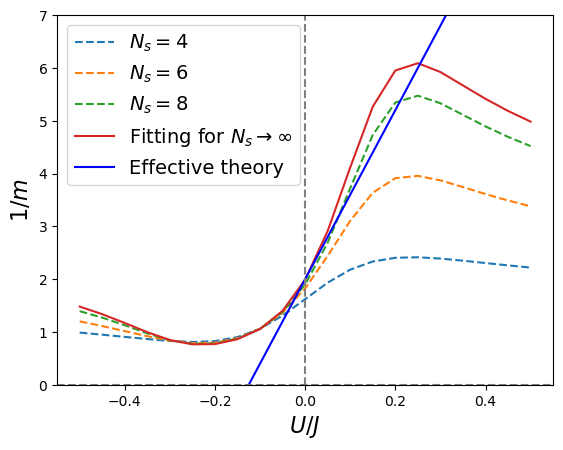

[1.40067282]
[1.99025569]
[2.91358293]
-0.04999999999999999


In [49]:


    
    
FD = np.array([plot_effective_mass[j,:,0,0]])    
    
second_derivative = np.zeros((len(ratios),len(Vs)))


for i in range(len(ratios)):
    for j in range(len(Vs)):
        fd = np.array([plot_effective_mass[0,i,j,0],plot_effective_mass[1,i,j,0],plot_effective_mass[2,i,j,0]])
        a , b = fit(fd,NS)
        
        plt.plot(NS,fd, "rx")
        plt.plot(np.linspace(0.01,10,100), fitting_second_derivative(np.linspace(0.01,10,100),a,b))
        plt.xlabel(r"$N_s$")
        plt.ylabel("Finite Difference")
        plt.title(r"$J/U = $"+str(ratios[i]))
        plt.ylim([-10,10])
        plt.show( )
        
        second_derivative[i,j] = a
        
        
for j in range(len(NS)):
    plt.plot(ratios,plot_effective_mass[j,:,0,0], label = r"$N_s = $"+str(NS[j]), ls = "--")    
plt.plot(ratios, second_derivative[:,0], label = r"Fitting for $N_s \rightarrow \infty$", ls = "-")
plt.plot(ratios,linear_mass_q0(ratios), color = "blue", ls = "-", label = "Effective theory")

plt.xlabel(r"$U/J$", fontsize = 16)
plt.ylabel(r"$1/m$", fontsize = 16)
plt.legend(fontsize = 14)
plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.ylim([0,7])
#plt.xlim([-0.05,0.05])
plt.show()
    
    
print(second_derivative[len(second_derivative)//2-1])
print(second_derivative[len(second_derivative)//2])
print(second_derivative[len(second_derivative)//2+1])
print(ratios[len(second_derivative)//2-1])

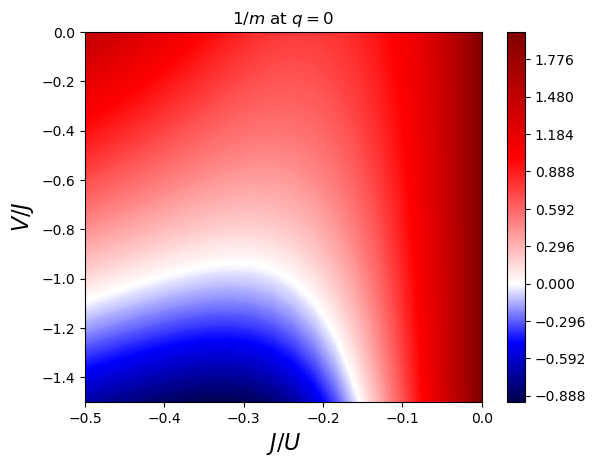

In [15]:
from matplotlib.colors import TwoSlopeNorm

plt.contourf(ratios,Vs,second_derivative.T,levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
#plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()

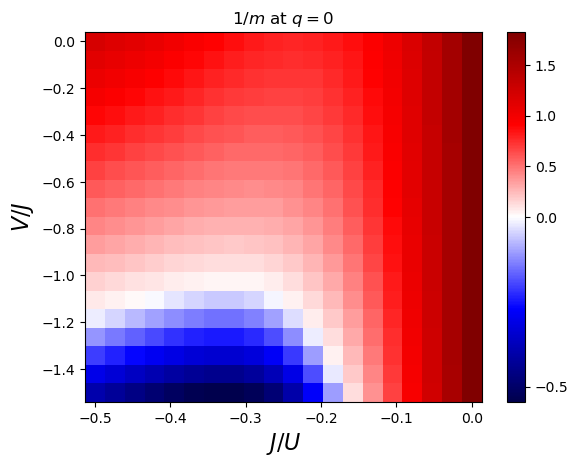

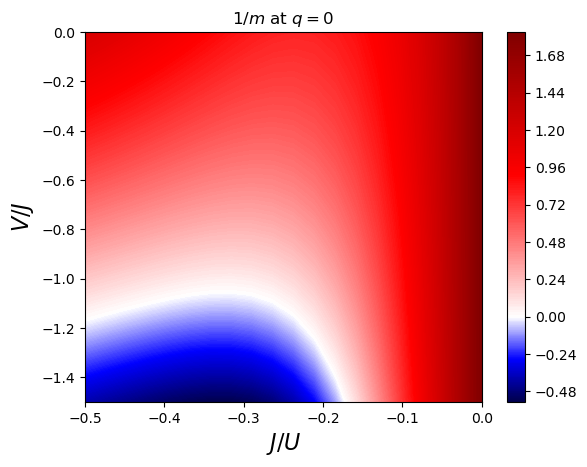

48.88184025453444
[5 5 5 6 6 6 6 6 6 6 5 4 2 0 0 0 0 0 0 0]


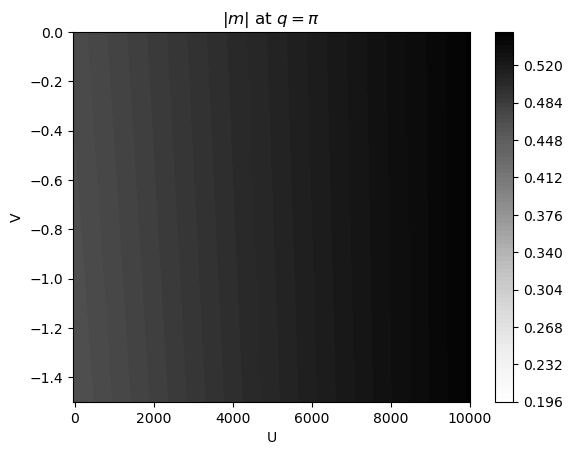

In [13]:
from matplotlib.colors import TwoSlopeNorm

#plt.contourf(ratios,Vs,(plot_effective_mass[0,:,:,0].T),levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()


plt.contourf(ratios,Vs,(plot_effective_mass[0,:,:,0].T),levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
#plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()

#print(1/plot_effective_mass[0,20,20,0].T)
#print(Vs[20])
#print(Us[20])

print(np.max(1/plot_effective_mass[0,:,:,0].T))
print(np.argmax(1/plot_effective_mass[0,:,:,0].T, axis = 0))

plt.contourf(Us,Vs,1/np.abs(plot_effective_mass[0,:,:,1].T),levels = 100, cmap = "Greys")
plt.xlabel("U")
plt.ylabel("V")
plt.colorbar()
plt.title(r"$|m|$ at $q = \pi$")
plt.show()

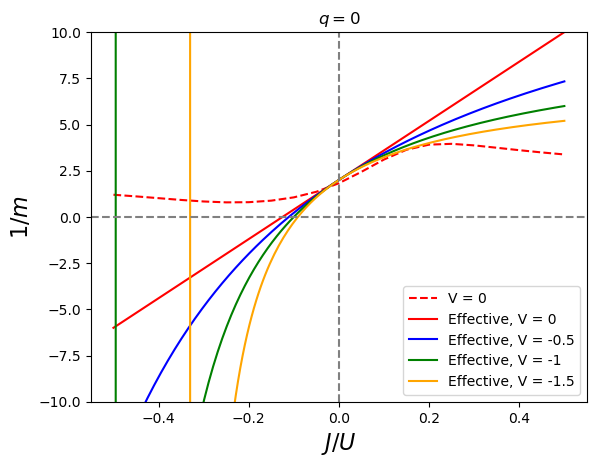

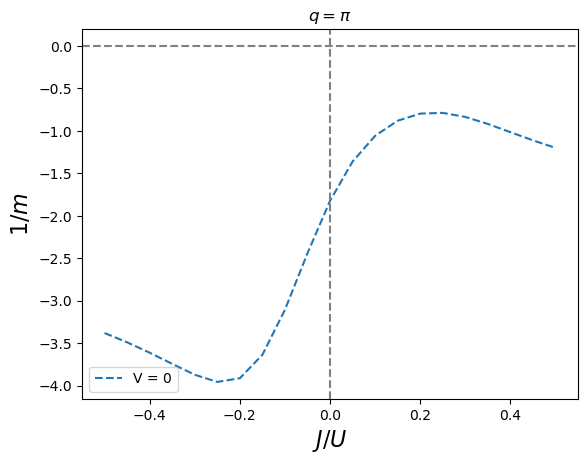

IndexError: index 25 is out of bounds for axis 0 with size 21

In [11]:
#plot_effective_mass[j,i,ik,0]

colors = ["red", "blue", "green", "orange"]
#plt.contourf(Us,Vs,plot_effective_mass[0,:,:,0].T,levels = 100, cmap = "Greys")
for i in range(len(Vs)):
        plt.plot(1/Us, plot_effective_mass[0,:,i,0], color = colors[i],ls = "--", label = "V = "+str(Vs[i]))
        
        
X = np.linspace(-0.5,0.5,200)
Us2 = 1/X

plt.plot(1/Us2,2+16/(Us2), "-", label = "Effective, V = 0", color = "red")
plt.plot(1/Us2,2+16/(Us2+1), "-", label = "Effective, V = -0.5", color = "blue")
plt.plot(1/Us2,2+16/(Us2+2+0.000001), "-", label = "Effective, V = -1", color = "green")

plt.plot(1/Us2,2+16/(Us2+3),label = "Effective, V = -1.5", color = "orange")
plt.xlabel(r"$J/U$", fontsize = 16)
#plt.ylabel(r"$V$", fontsize = 16)
#plt.xlim([0,4])
#plt.colorbar()
#plt.ylim([-1,4.5])
plt.ylim([-10,10])

plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.legend()
plt.ylabel(r"$1/m$", fontsize = 16)
plt.title(r"$q = 0$")
plt.show()

#plt.contourf(Us,Vs,plot_effective_mass[0,:,:,0].T,levels = 100, cmap = "Greys")
for i in range(len(Vs)):
    if (i <4):
        plt.plot(1/Us, plot_effective_mass[0,:,i,1], "--", label = "V = "+str(Vs[i]))
    else:
        plt.plot(1/Us, plot_effective_mass[0,:,i,1], "-", label = "V = "+str(Vs[i]))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.ylabel(r"$1/m$", fontsize = 16)
#plt.ylabel(r"$V$", fontsize = 16)
#plt.xlim([0,4])
#plt.colorbar()
plt.legend()
plt.title(r"$q = \pi$")
plt.show()

print(Us[25])

In [7]:
def funcion(suma,resta):
    return -4*np.cos(suma/2)*np.cos(resta/2)


def move_to_1bz(k):
    q = k.copy()
    while (q < -np.pi) or (q >= np.pi+0.01):
        #print(q)
        if (q < -(np.pi)):
            #print("hehe")
            q = q + (2*np.pi)
        else:
            q = q - 2*np.pi
            
        '''print("This can never be -3.141592: ", q)
        print("___")
        #if ((q + np.pi) < 1e-5):
        if (q == -np.pi):
            return q
        elif (q == np.pi):
            print(q)
            print("reach here")
            q = -np.pi
            return q'''
       
            
    if np.abs(q-np.pi) < 1e-6:
        q = -np.pi
            
  
    return q


def diagonalization_per_block(vector_of_q, H_Q):
    degeneracies = []
    energies = []
    #check = True
    deg = 1
    for i in range(1,len(vector_of_q)):
        #print(vector_of_q[i])
        if ((vector_of_q[i]  - vector_of_q[i-1]) < 1e-5):
            deg = deg + 1
            
            
        else:
            degeneracies.append(deg)
            deg = 1
            
            
    degeneracies.append(deg)
    
    degeneracies = np.array(degeneracies)
    #print(degeneracies)
    
    for i in range(len(degeneracies)):
        #my_new_matrix = np.zeros((degeneracies[i],degeneracies[i]), dtype = complex)
        my_new_matrix = lil_matrix((degeneracies[i],degeneracies[i]), dtype = complex)
        for j in range(degeneracies[i]):
            for k in range(degeneracies[i]):
                total_sum = 0
                for l in range(i):
                    total_sum = total_sum + degeneracies[l]
                my_new_matrix[j,k] = H_Q[j+total_sum,k+total_sum]
        if (degeneracies[i] > 2):        
            vaps_lower_band = eigs(my_new_matrix, k = 2, which='SR', return_eigenvectors = False)
            vaps_higher_band = eigs(my_new_matrix, k = 2, which='LR', return_eigenvectors = False)

            vaps_lower_band = np.sort(vaps_lower_band)
            vaps_higher_band = np.sort(vaps_higher_band)
        elif (degeneracies[i] == 1):
            vaps_lower_band = np.array([my_new_matrix[0,0]])
            vaps_higher_band = np.array([my_new_matrix[0,0]])
        elif (degeneracies[i] == 2):
            vaps, veps = LA.eigh(my_new_matrix.todense())
            vaps_lower_band = np.array([vaps[0]])
            vaps_higher_band = np.array([vaps[1]])
                
            
            
        '''
        vaps = eigs(my_new_matrix , k = 3, which = "SR", return_eigenvectors = False)
        vaps = np.sort(vaps)'''
        #vaps,veps = LA.eigh(my_new_matrix)
        
        #for m in range(len(vaps)):
        for m in range(degeneracies[i]):
            if (m < len(vaps_lower_band)):
                energies.append(np.real(vaps_lower_band[m]))
            elif (m > degeneracies[i] - len(vaps_higher_band) - 1):
                #print(m)
                energies.append(np.real(vaps_higher_band[m - degeneracies[i] + len(vaps_higher_band)]))
            else:
                energies.append(0)
        '''
        for m in range(degeneracies[i]):
            if m < len(vaps):
                energies.append(np.real(vaps[m]))
            else:
                energies.append(0)'''
    
    
    
    energies = np.array(energies)
    #print("energies", energies)
    
    return energies
    
    
def effective_dispersion_relation(q,U,Ns):
    #if (U != 0):
    return -2*np.cos(q) - 4/(U)*np.cos(2*q) + 8/U - 4/U*Ns
    #else:
     #   return -2*np.cos(q)

def effective_dispersion_relation_fermions(q,U,Ns):
    return 2*np.cos(q) - 4/(U)*np.cos(2*q) + 8/U - 4/U*Ns
    
    
def find_EQ1_EQ2(vector_q,vector_E, Ns):
    
    out = np.zeros((Ns,4))
    
    if (Ns%2 == 0):
        check = True
        for k in range(-Ns//2,Ns//2,1):
            q_check = k*2*np.pi/Ns
            check = True
            
            for i in range(len(vector_q)):
                if (i != len(vector_q) -1):
                    
                    if (np.abs(vector_q[i] - q_check) < 1e-6) and (check == True):
                        out[k+Ns//2,0] = vector_E[i]
                        out[k+Ns//2,2] = vector_E[i+1]
                        check = False
                        
                    if (check == False) and ((np.abs(vector_q[i] - vector_q[i+1]) > 1e-6)):
                        out[k+Ns//2,1] = vector_E[i]
                        out[k+Ns//2,3] = vector_E[i-1]
                        check = True
                else:
                    if (np.abs(vector_q[i] - q_check) < 1e-6):
                        out[k+Ns//2,1] = vector_E[i]
                        out[k+Ns//2,3] = vector_E[i-1]
                
    if (Ns%2 != 0):
        for k in range(-(Ns-1)//2,(Ns-1)//2+1,1):
            q_check = k*2*np.pi/Ns
            #print("check of q = ", q_check)
            check = True
            for i in range(len(vector_q)):
                #print("i = ", i)
                if (i != len(vector_q) - 1):
                    if (np.abs(vector_q[i] - q_check) < 1e-6) and (check == True):
                        #print("Lower level")
                        #print("before:",out[k+(Ns-1)//2,0])
                        out[k+(Ns-1)//2,0] = vector_E[i]
                        out[k+(Ns-1)//2,2] = vector_E[i+1]
                        #print("after:",out[k+(Ns-1)//2,0])
                        check = False
            
                    if (check == False) and ((np.abs(vector_q[i] - vector_q[i+1]) > 1e-3)):
                        
                        #print("Higher level")
                        #print("before",out[k+(Ns-1)//2,1])
                        out[k+(Ns-1)//2,1] = vector_E[i]
                        out[k+(Ns-1)//2,3] = vector_E[i-1]
                        #print("after",out[k+(Ns-1)//2,1])
                        check = True
    
                else:
                    if (np.abs(vector_q[i] - q_check) < 1e-6):
                        #print("Higher level")
                        #print("before",out[k+(Ns-1)//2,1])
                        out[k+(Ns-1)//2,1] = vector_E[i]
                        out[k+(Ns-1)//2,3] = vector_E[i-1]
                        #print("after",out[k+(Ns-1)//2,1])
            
            
            
            
            '''if (np.abs(vector_q[i]) < 1e-6) and (check1 == True):
                E_Q0 = vector_E[i]
                check1 = False
            if (np.abs(vector_q[i] - (2*np.pi/Ns)) < 1e-6) and (check2 == True):
                E_Q1 = vector_E[i]
                check2 = False'''
            
    return out




def bogoliubov_spectrum(q,a,m_inv,shift):
    #a = 0
    #return shift + np.sqrt((a**2)*4*np.sin(q/2)**2 + (1/m_inv*2*np.sin(q/2)**2)**2)
    return shift + np.sqrt(a**2*q**2 + (m_inv**2*4*np.sin(q/2)**4))
def parabolic_spectrum(q,m_inv):
    return m_inv*q**2/2
    
def curve_fit_bogoliubov(bands):
    Ns = len(bands)
    
    if (Ns%2 == 0):
        Q = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns
    if (Ns%2 != 0):
        Q = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns
    
    
    ydata0 = np.zeros(len(Q))
    ydata1 = np.zeros(len(Q))
    
    for i in range(len(ydata0)):
        #print(bands[i,0])
        
        ydata0[i] = bands[i,0]
        ydata1[i] = bands[i,1]
    
    g = [1, 2, 1]
    

    
    
    values, cov = curve_fit(bogoliubov_spectrum, Q, ydata0, g)#, bounds=((-0.001,-np.inf,-np.inf), (0.001,np.inf,np.inf)))
    
    a = values[0]
    
    m_inv = values[1]
    
    shift = values[2]
    
    #print("c varianice:", cov[0])
    #print("m varianice:", cov[1])
    #print("shift varianice:", cov[2])
    
    return m_inv, a, shift


def equation_system_ns6(E0,E1,E2):
    d1 = E1 - E0
    d2 = E2 - E0
    
    #first three states
    #m_inv = 1/(2/3*(d2)**2-2*d1**2)
    #c = 3/2*d1**2 - 1/6*d2**2
    
    
    #linear sound speed
    #m_inv = 4/5*d2**2 - 16/5*d1**2
    #c = (6/(4*np.pi))**2*(36/5*d1**2 - 4/5*d2**2)
    
    #frontier:
    m_inv = 4/5*d2**2 - 16/5*d1**2
    c = 9/5*d1**2 - 1/5*d2**2
    
    #print("m_inv = ", m_inv)
    #print("c = ", c)
    
    
    #return np.sqrt(np.abs(m_inv2)), np.sqrt(np.abs(c2))
    return np.sqrt(m_inv), np.sqrt(c)



def inverse_mass_q2pins(J,U,Ns):
    return 2*J*np.cos(2*np.pi/Ns) - 16*J**2/U*np.cos(4*np.pi/Ns)
